In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits

In [118]:
def extract_spectrum(path, namefile):
    """
    Extracts spectrum data from a FITS file and cleans it by removing a specified wavelength range,
    addressing negative flux values, and ensuring it starts at 4280 Ångstrom.
    
    Arguments:
    path (str): The path to the directory containing the FITS file.
    namefile (str): The name of the FITS file.
    
    Returns:
    tuple: A tuple containing cleaned wavelengths and flux data.
    """
    with fits.open(path + namefile) as hdul:
        flux = hdul[1].data
        nx, wav0, i0, dwav = [hdul[1].header[k] for k in ("NAXIS1", "CRVAL1", "CRPIX1", "CD1_1")]
        wavelengths = wav0 + (np.arange(nx) - (i0 - 1)) * dwav
        wavelengths *= 10  # Convert to angstroms
    
    # Define the range to remove
    remove_range = (wavelengths >= 6120) & (wavelengths <= 6380)
    
    # Apply the filter
    clean_wavelengths = wavelengths[~remove_range]
    clean_flux = flux[~remove_range]
    
    # Address negative flux values
    negative_flux_indices = clean_flux < 0
    clean_flux[negative_flux_indices] = 0  # Set negative flux values to zero
    # Alternatively, you can choose to take the absolute value:
    # clean_flux[negative_flux_indices] = np.abs(clean_flux[negative_flux_indices])
    
    # Ensure the spectrum starts at 4280 Ångstrom
    start_index = np.searchsorted(clean_wavelengths, 4280)  # Find index closest to 4280
    clean_wavelengths = clean_wavelengths[start_index:]
    clean_flux = clean_flux[start_index:]
    clean_flux /=1e-18

    return clean_wavelengths, clean_flux

In [181]:
def plot_spectrum(wavelengths, flux, emission_lines, z=0.0, xlim=None, ylim=None):
    """
    Plots spectrum and annotates known emission lines.
    
    Arguments:
    wavelengths (array): Array of wavelengths.
    flux (array): Array of flux values.
    emission_lines (dict): Dictionary containing emission lines and their corresponding wavelengths.
    z (float): Redshift value (default is 0.0).
    xlim (tuple): Tuple containing the x-axis limits for the plot (optional).
    ylim (tuple): Tuple containing the y-axis limits for the plot (optional).
    """
    # Calculate observed wavelengths with redshift
    observed_wavelengths = wavelengths * (1 + z)

    # Calculate max flux around emission lines for label positioning
    max_flux = []
    for wavelength in emission_lines.values():
        lambda_ob = wavelength * (z + 1)
        j = lambda_ob  - 10
        k = lambda_ob  + 10
        mask = (j < wavelengths) & (wavelengths < k)
        flux_values = flux[mask]
        try:
            max_flux.append(np.max(flux_values))
        except ValueError:
            max_flux.append(10)

    # Plotting
    color_palette = sns.color_palette('Paired', 12)
    with sns.axes_style('white'):
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.set_xlabel(r'Wavelength $(\AA)$', fontsize=20)
        ax.set_ylabel(r'Flux ($\mathrm{10^{-18} erg\ s^{-1} cm^{-2} \AA^{-1}}$)', fontsize=20)
        ax.tick_params(axis='x', labelsize=18)
        ax.tick_params(axis='y', labelsize=18)
        ax.plot(wavelengths, flux, c="black")
        for label_, wll in emission_lines.items():
            wll_ob = wll * (z + 1)
            ax.axvline(wll * (z + 1), color='k', linewidth=0.6, alpha=0.5, linestyle='--')
            bbox_props = dict(boxstyle="round", fc="w", ec="0.88", alpha=0.8, pad=0.1)
            max_flux_val = max_flux[list(emission_lines.keys()).index(label_)]  # corrected line
            ax.annotate(label_, (wll_ob, max_flux_val), alpha=1, size=12,
                        xytext=(6.0, 5.6), textcoords='offset points', ha='right', va='bottom',
                        rotation=90, bbox=bbox_props, zorder=200)

    # Set limits if provided
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    #plt.savefig(path + namefile.replace(".fits", ".pdf"))
    plt.show()  # Add this line if you want to display the plot .

In [186]:
# Emission lines
emission_lines = {
        "Hγ": 4340.471, 
        "[O III] 4363": 4363.21,
        "O II 4591": 4601.48,
        "Hβ": 4861.33,
        "[O III] 4958": 4958.911,
        "[O III] 5007": 5006.843,
        "He I 5876": 5875.66,     
        "Hα": 6562.82,
        "[N II] 6584": 6583.50,
        "[S II] 6716": 6716.44,
        "[S II] 6731": 6730.82,
        "[Ar III] 7135": 7135,
        "[O II] 7319": 7319.45,
        "[O II] 7330": 7330.20,
        "[Ar III] 7751": 7751,
        "He II 8236": 8236.79,
        "He I 8997?": 8997.99
    }

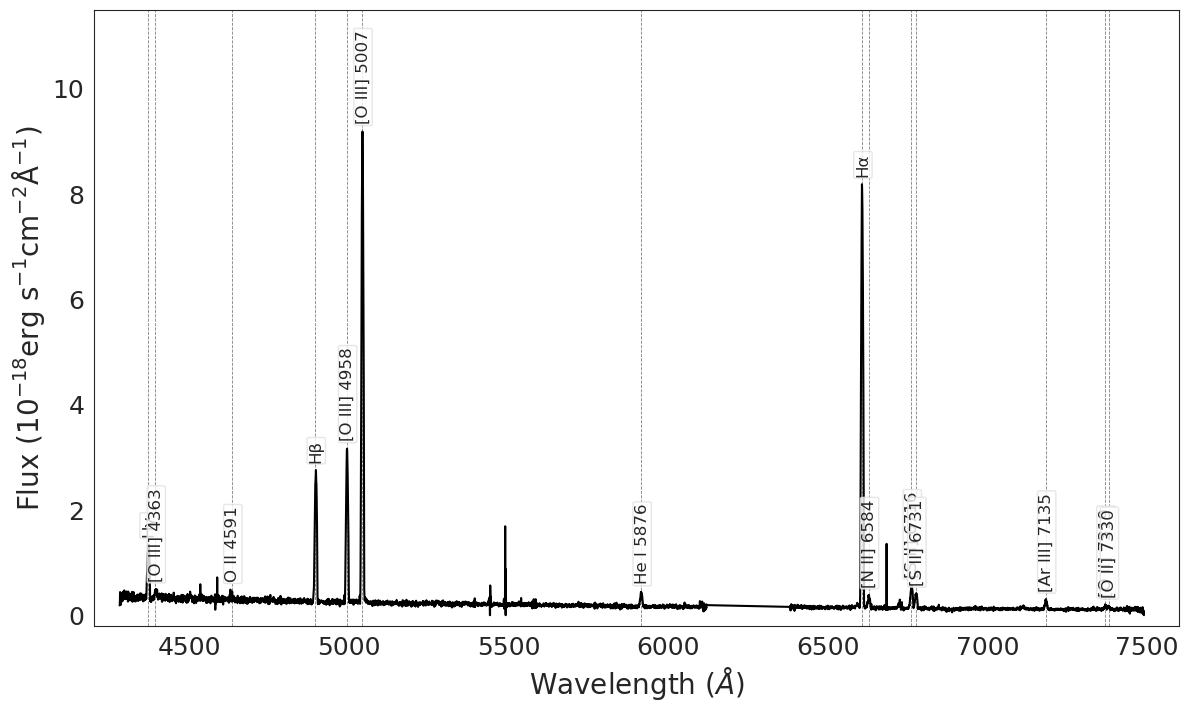

In [187]:
# Example usage
path = "../spectra_luis/"
namefile = "n02n27_1D_aberturaOIII_test.fits"
z = 0.0067
wavelengths, flux = extract_spectrum(path, namefile)
plot_spectrum(wavelengths, flux, emission_lines, z=z, xlim=(4200, 7600), ylim=(-0.2, 11.5))